# Introduction

In this notebook, we will implement the standard method of Collaborative Filtering with the Pareto Dominance. It is inspired by this paper: 
http://www.sciencedirect.com/science/article/pii/S0020025513002004

In [1]:
# Import the fucking useful libraries =)
import pandas as pd
import numpy as np

import os
import matplotlib.pyplot as plt
from helpers_CF_and_PD import *
import scipy.stats as sp
import scipy.spatial.distance as spsd
from operator import itemgetter
import random
from IPython import display

%matplotlib inline
%load_ext autoreload
%autoreload 2

# There's a lot of columns in the DF. 
# Therefore, we add this option so that we can see more columns
pd.options.display.max_columns = 100

In [2]:
# Define here the data set
dataset = '../../data/data_train.csv'

# Load the data and prepare them


In [3]:
data = prepare_data(dataset)
# Prepare the data
U, I, R, I_u = variables(data)

Load the dataset
Prepare the variables


Get the sets of non-dominated users. (Already calculated)

In [4]:
# Folder for the preprocessing file
folder = "./pickles/"

non_dom_users_file = folder + "non-dominated-users.pickle"

# Get the file
C = get_pickle(non_dom_users_file)

# Make some tests

In order to make sure that the preprocessing is correct, we need to plot some graph

In [ ]:
# We define an array of values equals to number of candidates over number of items rated
c_over_ir = []
nbr_cand = []
nbr_itms = []
for usr in U:
    c_over_ir.append(len(C[usr])/len(I_u[usr]))
    nbr_cand.append(len(C[usr]))
    nbr_itms.append(len(I_u[usr]))
len(c_over_ir)

In [ ]:
n, bins, patches = plt.hist(c_over_ir, 50, facecolor='black', alpha=0.75)
plt.xlabel('Number of candidates / Number of items rated')
plt.ylabel('Number of users')

In [ ]:
n, bins, patches = plt.hist(nbr_cand, 50, facecolor='black', alpha=0.75)
plt.xlabel('Number of candidates')
plt.ylabel('Number of users')

In [ ]:
n, bins, patches = plt.hist(nbr_itms, 50, facecolor='black', alpha=0.75)
plt.xlabel('Number of items rated')
plt.ylabel('Number of users')

In [ ]:
nbr_itms.index(min(nbr_itms))

In [ ]:
len(C[480])

In [ ]:
nbr_cand.index(min(nbr_cand))

In [ ]:
nbr_itms[3677]

Difficult to say if it worked or not.. But it seems ok... =)

# Nearest Neighbors

Now, we create the list of arrays of nearest neighbors for each user using the three different functions

In [90]:
NN_pearson_file = folder + "NN_pearson.pickle"
NN_cosine_file = folder + "NN_cosine.pickle"
NN_msd_file = folder + "NN_msd.pickle"
NN_files = [NN_pearson_file, NN_cosine_file, NN_msd_file]

# Training

Now, we just have to do the training. First, we cut into training and testing data.

In [6]:
# Before having the train and testing set, we need to unload the memory a bit
del C
del U
del I
del R
del I_u

In [7]:
def training_testing(data, p_value=0.1):
    test_array = []
    train_array = []
    for i in range(len(data)):
        if random.random() < p_value:
            test_array.append(data.iloc[i])
        else:
            train_array.append(data.iloc[i])
            
    variables = list(train_array[0].keys())
    
    train = pd.DataFrame([[getattr(i,j) for j in variables] for i in train_array], columns = variables)
    test = pd.DataFrame([[getattr(i,j) for j in variables] for i in test_array], columns = variables)

    return train, test            

In [8]:
train, test = training_testing(data)

In [10]:
# Create training matrices
U_train, I_train, R_train, I_u_train = variables(data)

Prepare the variables


In [81]:
KK = [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000] #, 1100, 1200, 1300,
    #1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500]

In [84]:
def rmse(a,b):
    return np.sqrt(np.mean((np.array(a)-np.array(b))**2))

def mean(vec, u, R):
    if len(vec) == 0:
        ratings_user = R[u,:]
        return np.mean(ratings_user[ratings_user!=np.inf])
    else:
        return np.mean(vec)

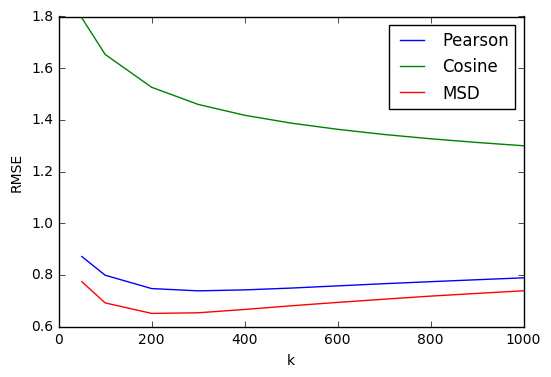

In [92]:
RMSE = np.zeros((len(NN_files), len(KK)))
for neigh_type in range(len(NN_files)):
    NN = get_pickle(NN_files[neigh_type])
    for idx, k in enumerate(KK):
        ratings = []
        pred = []
        n = len(test)
        #n = 100
        for i in range(n):
            usr = test.iloc[i].loc["UserID"]
            movie = test.iloc[i].loc["MovieID"]
            if k>len(NN[usr]):
                neigh = NN[usr]
            else:
                neigh = NN[usr][:k]

            G = R_train[neigh, movie]
            G = G[G!=np.inf]
            ratings.append(mean(G, usr, R_train))
            pred.append(test.iloc[i].loc["Prediction"])
        RMSE[neigh_type, idx] = rmse(ratings, pred)
        plt.gca().cla() 
        plt.plot(KK, RMSE[0,:], label='Pearson')
        plt.plot(KK, RMSE[1,:], label='Cosine')
        plt.plot(KK, RMSE[2,:], label='MSD')
        plt.xlabel("k")
        plt.ylabel("RMSE")
        plt.legend()
        display.display(plt.gcf())
        display.clear_output(wait=True)
    del NN

In [124]:
best_nn = np.argmin(np.min(RMSE, axis=1))
best_nn

2

In [120]:
best_k = KK[np.argmin(RMSE[best_nn,:])]
best_k

200

# Testing

Load the test data and apply the Recommendation

In [134]:
# Test data
dataset_test = '../../data/sampleSubmission.csv'
data_test = prepare_data(dataset_test)

# Training data
data = prepare_data(dataset)
# Prepare the data
U, I, R, I_u = variables(data)

Load the dataset
Load the dataset
Prepare the variables


In [135]:
data_test.head()

,Id,Prediction,UserID,MovieID
0,r37_c1,3,36,0
1,r73_c1,3,72,0
2,r156_c1,3,155,0
3,r160_c1,3,159,0
4,r248_c1,3,247,0


In [136]:
NN = get_pickle(NN_files[best_nn])
pred = []
best_k = 1000
for i in range(len(data_test)):
    usr = data_test.iloc[i].loc["UserID"]
    movie = data_test.iloc[i].loc["MovieID"]
    if best_k>len(NN[usr]):
        neigh = NN[usr]
    else:
        neigh = NN[usr][:best_k]

    G = R[neigh, movie]
    G = G[G!=np.inf]
    pred.append(mean(G, usr, R_train))
    
    if (i+1)%100000 == 0:
        print("%i/%i done!"%(i+1, len(data_test)))
del NN

100000/1176952 done!
200000/1176952 done!
300000/1176952 done!
400000/1176952 done!
500000/1176952 done!
600000/1176952 done!
700000/1176952 done!
800000/1176952 done!
900000/1176952 done!
1000000/1176952 done!
1100000/1176952 done!


In [140]:
data_test['Prediction'] = pred

In [141]:
data_test = data_test.drop(['UserID', 'MovieID'], axis=1)

ValueError: labels ['UserID' 'MovieID'] not contained in axis

In [142]:
data_test.to_csv('pred_PD_CF.csv', index=False)

In [143]:
data_test.head()

,Id,Prediction
0,r37_c1,3.692308
1,r73_c1,3.100000
2,r156_c1,3.629630
3,r160_c1,3.545455
4,r248_c1,3.000000
